## Fairness Analysis of NamSor's Gender API Endpoint using Aequitas

Part I: Fairness of Gender API Endpoint by Gender and Ethnicity

In [1]:
import pandas as pd
import seaborn as sns
from aequitas.group import Group
from aequitas.bias import Bias
from aequitas.fairness import Fairness
from aequitas.plotting import Plot

# import warnings; warnings.simplefilter('ignore')

%matplotlib inline

In [2]:
df = pd.read_csv("data/compas_gender_predictions.csv")
df.head()

,Unnamed: 0,entity_id,first,last,sex,sex_pred,race,score,label_value
0,0,1,miguel,hernandez,Male,Male,Other,0.000714,1.0
1,1,3,kevon,dixon,Male,Male,African-American,0.043280,1.0
2,2,4,ed,philo,Male,Male,African-American,0.031187,1.0
3,3,5,marcu,brown,Male,Male,African-American,0.377335,1.0
4,4,6,bouthy,pierrelouis,Male,Male,Other,0.490869,1.0


In [3]:
# Non String columns will lead to problems later so we have to find out if there are any
non_attr_cols = ['id', 'model_id', 'entity_id', 'score', 'label_value', 'rank_abs', 'rank_pct']
attr_cols = df.columns[~df.columns.isin(non_attr_cols)]  # index of the columns that are
df.columns[(df.dtypes != object) & (df.dtypes != str) & (df.columns.isin(attr_cols))]

Index(['Unnamed: 0'], dtype='object')

In [4]:
# And delete them.
df = df.drop(['Unnamed: 0'], axis=1)
df.head()

,entity_id,first,last,sex,sex_pred,race,score,label_value
0,1,miguel,hernandez,Male,Male,Other,0.000714,1.0
1,3,kevon,dixon,Male,Male,African-American,0.043280,1.0
2,4,ed,philo,Male,Male,African-American,0.031187,1.0
3,5,marcu,brown,Male,Male,African-American,0.377335,1.0
4,6,bouthy,pierrelouis,Male,Male,Other,0.490869,1.0


In [5]:
# we only want to look at gender here, since that is what we calculated label_value for
df = df.drop(['sex_pred', 'first', 'last'], axis=1) # if we don't drop the tables, Aequitas thinks these are attributes by which groups should be separated

In [6]:
df.shape

(7214, 5)

## Group Metrics

In [7]:
t = 0.2

In [8]:
g = Group()
xtab, _ = g.get_crosstabs(df, attr_cols=["sex", "race"], score_thresholds= {'score': [t]})
absolute_metrics = g.list_absolute_metrics(xtab)

model_id, score_thresholds 0 {'score': [0.05]}


In [9]:
xtab[[col for col in xtab.columns if col not in absolute_metrics]]

,model_id,score_threshold,k,attribute_name,attribute_value,pp,pn,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities
0,0,0.05_ore,5662,sex,Female,1109,286,42,222,64,1067,1289,106,1395,7214
1,0,0.05_ore,5662,sex,Male,4553,1266,142,1062,204,4411,5473,346,5819,7214
2,0,0.05_ore,5662,race,African-American,2682,1014,113,835,179,2569,3404,292,3696,7214
3,0,0.05_ore,5662,race,Asian,17,15,1,14,1,16,30,2,32,7214
4,0,0.05_ore,5662,race,Caucasian,2156,298,54,252,46,2102,2354,100,2454,7214
5,0,0.05_ore,5662,race,Hispanic,551,86,4,73,13,547,620,17,637,7214
6,0,0.05_ore,5662,race,Native American,15,3,0,1,2,15,16,2,18,7214
7,0,0.05_ore,5662,race,Other,241,136,12,109,27,229,338,39,377,7214


In [10]:
xtab[['attribute_name', 'attribute_value'] + absolute_metrics].round(2)

,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,ppr,pprev,prev
0,sex,Female,0.83,0.60,0.78,0.04,0.40,0.17,0.22,0.96,0.20,0.79,0.92
1,sex,Male,0.81,0.59,0.84,0.03,0.41,0.19,0.16,0.97,0.80,0.78,0.94
2,race,African-American,0.75,0.61,0.82,0.04,0.39,0.25,0.18,0.96,0.47,0.73,0.92
3,race,Asian,0.53,0.50,0.93,0.06,0.50,0.47,0.07,0.94,0.00,0.53,0.94
4,race,Caucasian,0.89,0.46,0.85,0.03,0.54,0.11,0.15,0.97,0.38,0.88,0.96
5,race,Hispanic,0.88,0.76,0.85,0.01,0.24,0.12,0.15,0.99,0.10,0.86,0.97
6,race,Native American,0.94,1.00,0.33,0.00,0.00,0.06,0.67,1.00,0.00,0.83,0.89
7,race,Other,0.68,0.69,0.80,0.05,0.31,0.32,0.20,0.95,0.04,0.64,0.90


### Visualize Group Metrics

In [11]:
aq_palette = sns.diverging_palette(225, 35, n=2)
aqp = Plot()

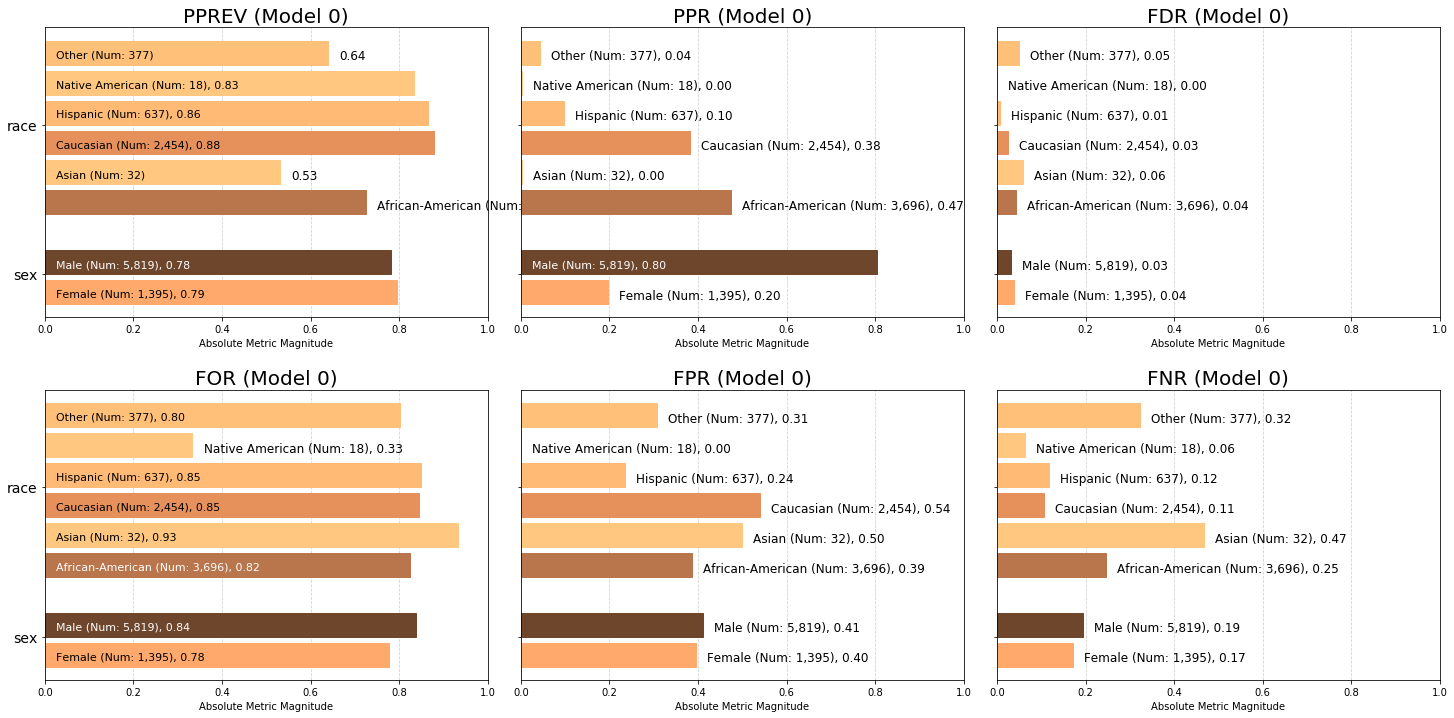

<Figure size 432x288 with 0 Axes>

In [12]:
a = aqp.plot_group_metric_all(xtab, ncols=3)

## Disparities of Group Metrics

In [13]:
b = Bias()
df.head()

,entity_id,sex,race,score,label_value
0,1,Male,Other,0.000714,1.0
1,3,Male,African-American,0.043280,1.0
2,4,Male,African-American,0.031187,1.0
3,5,Male,African-American,0.377335,1.0
4,6,Male,Other,0.490869,1.0


#### Disparities calculated in relation to a user-specified group for each attribute

In [14]:
bdf = b.get_disparity_predefined_groups(xtab, original_df=df, 
                                        ref_groups_dict={'sex':'Male', 'race':'Caucasian'}, 
                                        alpha=0.05, check_significance=False, 
                                        mask_significance=False)
bdf.style

get_disparity_predefined_group()


,model_id,score_threshold,k,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,pp,pn,ppr,pprev,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities,prev,ppr_disparity,pprev_disparity,precision_disparity,fdr_disparity,for_disparity,fpr_disparity,fnr_disparity,tpr_disparity,tnr_disparity,npv_disparity,ppr_ref_group_value,pprev_ref_group_value,precision_ref_group_value,fdr_ref_group_value,for_ref_group_value,fpr_ref_group_value,fnr_ref_group_value,tpr_ref_group_value,tnr_ref_group_value,npv_ref_group_value
0,0,0.05_ore,5662,sex,Female,0.827773,0.603774,0.776224,0.037872,0.396226,0.172227,0.223776,0.962128,1109,286,0.195867,0.794982,42,222,64,1067,1289,106,1395,7214,0.924014,0.243576,1.01603,0.993101,1.2143,0.925329,0.965453,0.887567,1.02707,1.02405,1.38873,Male,Male,Male,Male,Male,Male,Male,Male,Male,Male
1,0,0.05_ore,5662,sex,Male,0.805957,0.589595,0.838863,0.0311882,0.410405,0.194043,0.161137,0.968812,4553,1266,0.804133,0.782437,142,1062,204,4411,5473,346,5819,7214,0.94054,1,1,1,1,1,1,1,1,1,1,Male,Male,Male,Male,Male,Male,Male,Male,Male,Male
2,0,0.05_ore,5662,race,African-American,0.7547,0.613014,0.823471,0.0421327,0.386986,0.2453,0.176529,0.957867,2682,1014,0.473684,0.725649,113,835,179,2569,3404,292,3696,7214,0.920996,1.24397,0.825948,0.982475,1.68219,0.973788,0.716641,2.29141,0.845178,1.33264,1.1436,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian
3,0,0.05_ore,5662,race,Asian,0.533333,0.5,0.933333,0.0588235,0.5,0.466667,0.0666667,0.941176,17,15,0.00300247,0.53125,1,14,1,16,30,2,32,7214,0.9375,0.00788497,0.604679,0.965355,2.34858,1.1037,0.925926,4.35926,0.597272,1.08696,0.431884,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian
4,0,0.05_ore,5662,race,Caucasian,0.892948,0.46,0.845638,0.0250464,0.54,0.107052,0.154362,0.974954,2156,298,0.380784,0.878566,54,252,46,2102,2354,100,2454,7214,0.95925,1,1,1,1,1,1,1,1,1,1,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian
5,0,0.05_ore,5662,race,Hispanic,0.882258,0.764706,0.848837,0.00725953,0.235294,0.117742,0.151163,0.99274,551,86,0.0973154,0.864992,4,73,13,547,620,17,637,7214,0.973312,0.255566,0.98455,1.01824,0.289843,1.00378,0.43573,1.09986,0.988028,1.6624,0.979272,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian
6,0,0.05_ore,5662,race,Native American,0.9375,1,0.333333,0,0,0.0625,0.666667,1,15,3,0.00264924,0.833333,0,1,2,15,16,2,18,7214,0.888889,0.00695733,0.948516,1.02569,0,0.39418,0,0.583829,1.04989,2.17391,4.31884,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian
7,0,0.05_ore,5662,race,Other,0.677515,0.692308,0.801471,0.0497925,0.307692,0.322485,0.198529,0.950207,241,136,0.0425645,0.639257,12,109,27,229,338,39,377,7214,0.896552,0.111781,0.727615,0.974618,1.98801,0.947771,0.569801,3.01242,0.758739,1.50502,1.28613,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian


In [15]:
# View disparity metrics added to dataframe
bdf[['attribute_name', 'attribute_value'] +
     b.list_disparities(bdf) + b.list_significance(bdf)].style

,attribute_name,attribute_value,ppr_disparity,pprev_disparity,precision_disparity,fdr_disparity,for_disparity,fpr_disparity,fnr_disparity,tpr_disparity,tnr_disparity,npv_disparity
0,sex,Female,0.243576,1.01603,0.993101,1.2143,0.925329,0.965453,0.887567,1.02707,1.02405,1.38873
1,sex,Male,1,1,1,1,1,1,1,1,1,1
2,race,African-American,1.24397,0.825948,0.982475,1.68219,0.973788,0.716641,2.29141,0.845178,1.33264,1.1436
3,race,Asian,0.00788497,0.604679,0.965355,2.34858,1.1037,0.925926,4.35926,0.597272,1.08696,0.431884
4,race,Caucasian,1,1,1,1,1,1,1,1,1,1
5,race,Hispanic,0.255566,0.98455,1.01824,0.289843,1.00378,0.43573,1.09986,0.988028,1.6624,0.979272
6,race,Native American,0.00695733,0.948516,1.02569,0,0.39418,0,0.583829,1.04989,2.17391,4.31884
7,race,Other,0.111781,0.727615,0.974618,1.98801,0.947771,0.569801,3.01242,0.758739,1.50502,1.28613


### Visualizing disparities

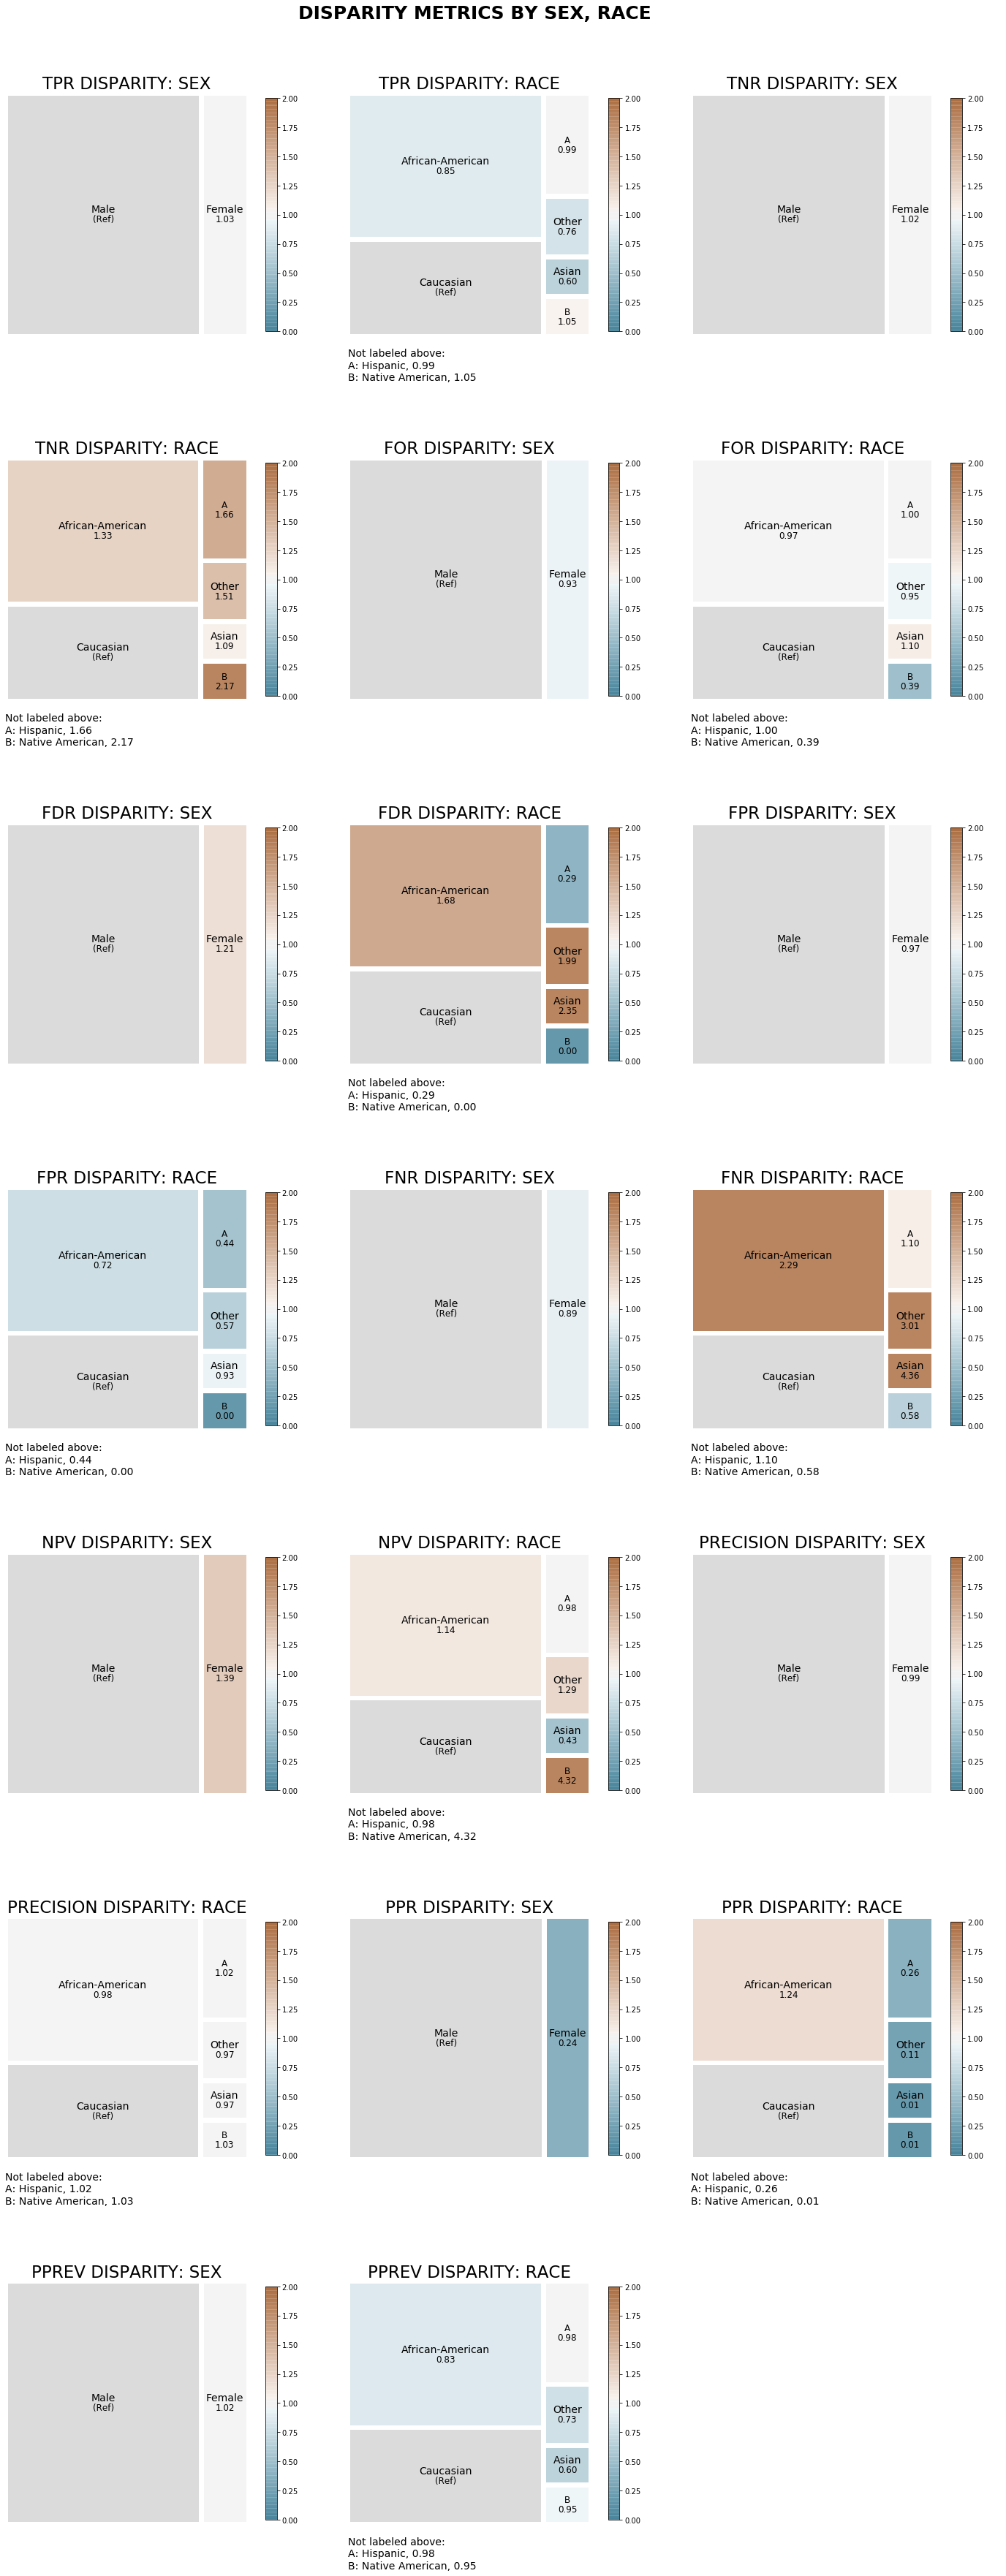

In [16]:
tm_capped = aqp.plot_disparity_all(bdf, attributes=['sex', 'race'], metrics = 'all', significance_alpha=0.05)

## Fairness Metrics

In [17]:
f = Fairness()
fdf = f.get_group_value_fairness(bdf)

In [18]:
parity_detrminations = f.list_parities(fdf)

In [19]:
fdf[['attribute_name', 'attribute_value'] + absolute_metrics + b.list_disparities(fdf) + parity_detrminations].style

,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,ppr,pprev,prev,ppr_disparity,pprev_disparity,precision_disparity,fdr_disparity,for_disparity,fpr_disparity,fnr_disparity,tpr_disparity,tnr_disparity,npv_disparity,TypeI Parity,Unsupervised Fairness,Precision Parity,Statistical Parity,FDR Parity,FPR Parity,Impact Parity,TNR Parity,FOR Parity,TPR Parity,TypeII Parity,FNR Parity,NPV Parity,Equalized Odds,Supervised Fairness
0,sex,Female,0.827773,0.603774,0.776224,0.037872,0.396226,0.172227,0.223776,0.962128,0.195867,0.794982,0.924014,0.243576,1.01603,0.993101,1.2143,0.925329,0.965453,0.887567,1.02707,1.02405,1.38873,True,False,True,False,True,True,True,True,True,True,True,True,False,True,True
1,sex,Male,0.805957,0.589595,0.838863,0.0311882,0.410405,0.194043,0.161137,0.968812,0.804133,0.782437,0.94054,1,1,1,1,1,1,1,1,1,1,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
2,race,African-American,0.7547,0.613014,0.823471,0.0421327,0.386986,0.2453,0.176529,0.957867,0.473684,0.725649,0.920996,1.24397,0.825948,0.982475,1.68219,0.973788,0.716641,2.29141,0.845178,1.33264,1.1436,False,True,True,True,False,False,True,False,True,True,False,False,True,False,False
3,race,Asian,0.533333,0.5,0.933333,0.0588235,0.5,0.466667,0.0666667,0.941176,0.00300247,0.53125,0.9375,0.00788497,0.604679,0.965355,2.34858,1.1037,0.925926,4.35926,0.597272,1.08696,0.431884,False,False,True,False,False,True,False,True,True,False,False,False,False,False,False
4,race,Caucasian,0.892948,0.46,0.845638,0.0250464,0.54,0.107052,0.154362,0.974954,0.380784,0.878566,0.95925,1,1,1,1,1,1,1,1,1,1,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
5,race,Hispanic,0.882258,0.764706,0.848837,0.00725953,0.235294,0.117742,0.151163,0.99274,0.0973154,0.864992,0.973312,0.255566,0.98455,1.01824,0.289843,1.00378,0.43573,1.09986,0.988028,1.6624,0.979272,False,False,True,False,False,False,True,False,True,True,True,True,True,False,False
6,race,Native American,0.9375,1,0.333333,0,0,0.0625,0.666667,1,0.00264924,0.833333,0.888889,0.00695733,0.948516,1.02569,0,0.39418,0,0.583829,1.04989,2.17391,4.31884,False,False,True,False,False,False,True,False,False,True,False,False,False,False,False
7,race,Other,0.677515,0.692308,0.801471,0.0497925,0.307692,0.322485,0.198529,0.950207,0.0425645,0.639257,0.896552,0.111781,0.727615,0.974618,1.98801,0.947771,0.569801,3.01242,0.758739,1.50502,1.28613,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False


In [20]:
gaf = f.get_group_attribute_fairness(fdf)
gaf

,model_id,score_threshold,attribute_name,Statistical Parity,Impact Parity,FDR Parity,FPR Parity,FOR Parity,FNR Parity,TPR Parity,TNR Parity,NPV Parity,Precision Parity,TypeI Parity,TypeII Parity,Equalized Odds,Unsupervised Fairness,Supervised Fairness
0,0,0.05_ore,race,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
1,0,0.05_ore,sex,False,True,True,True,True,True,True,True,False,True,True,True,True,False,True


In [21]:
gof = f.get_overall_fairness(fdf)
gof

{'Unsupervised Fairness': False,
 'Supervised Fairness': False,
 'Overall Fairness': False}

### Visualize fairness

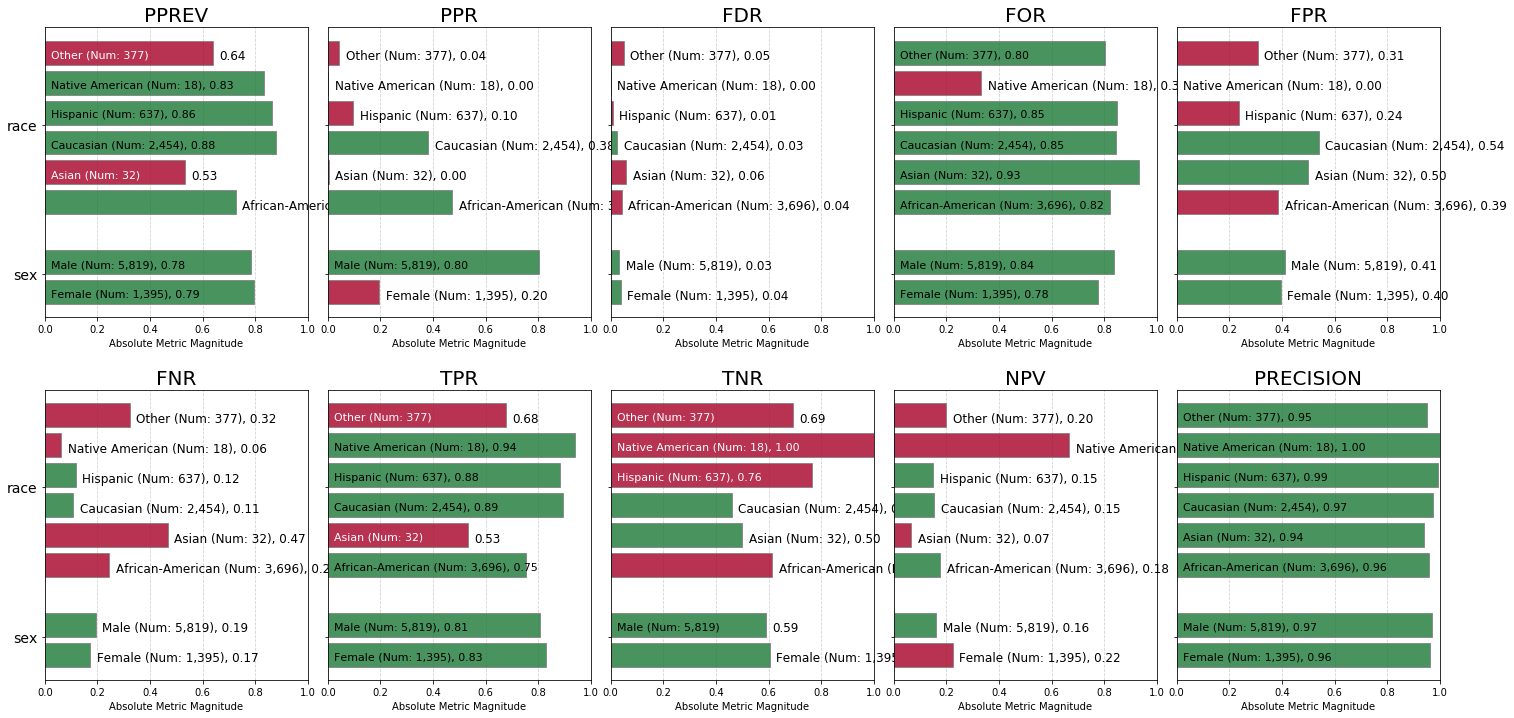

<Figure size 432x288 with 0 Axes>

In [22]:
fg = aqp.plot_fairness_group_all(fdf, ncols=5, metrics = "all")

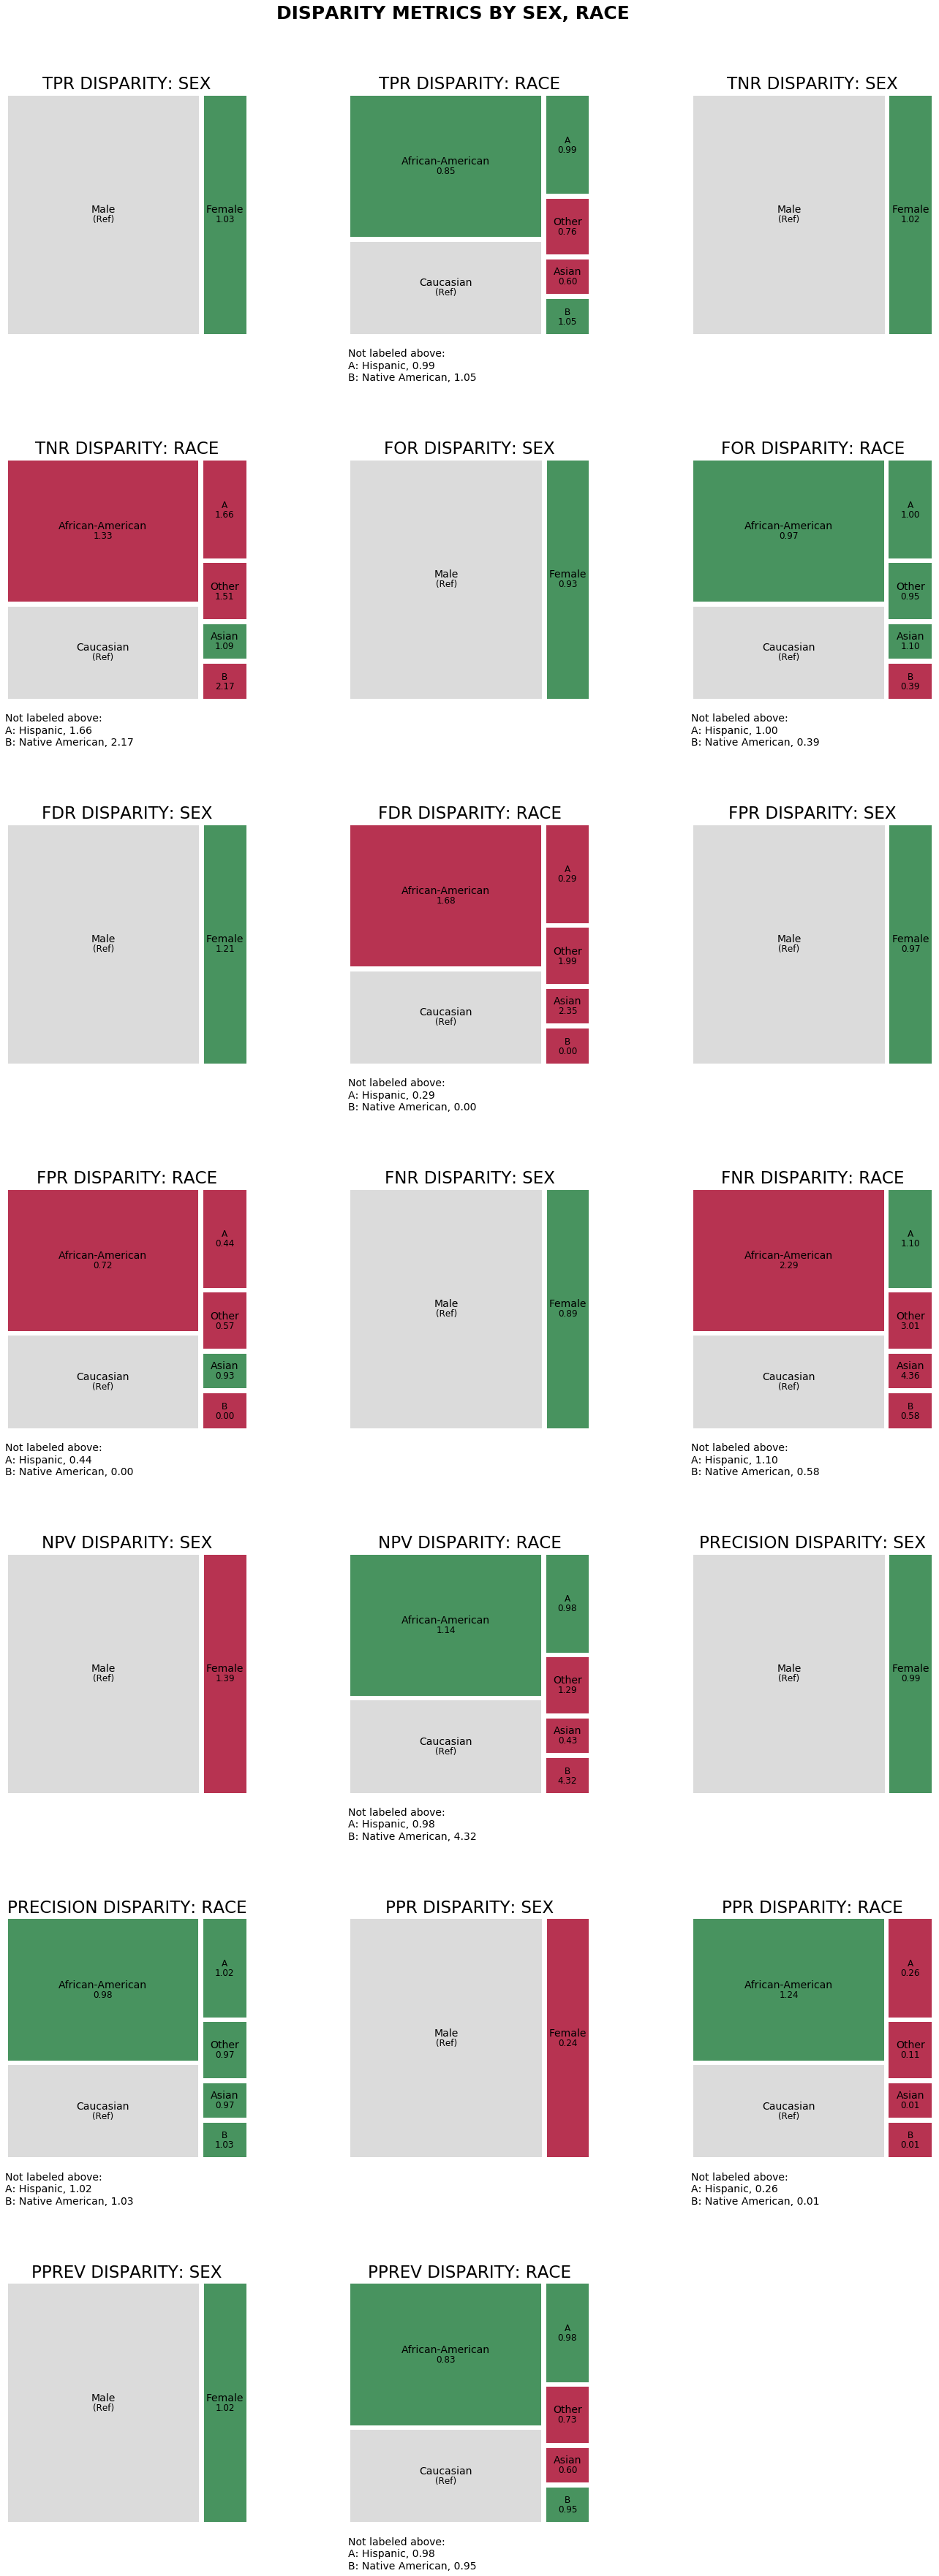

In [23]:
a_tm = aqp.plot_fairness_disparity_all(fdf, attributes=['sex', 'race'], metrics='all', 
                                       significance_alpha=0.05)